# Here we compare the Results of ChatGPT against the manuell Results

In [70]:
import pandas as pd
import numpy as np
import re, sys
from support_functions.excel_helper import save_to_excel, prepaire_excel_data, load_datasets_add_line_counter
from support_functions.load_json_chatgpt_results import load_chat_gpt_results
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment
from openpyxl.worksheet.worksheet import Worksheet
from openpyxl.utils import get_column_letter as utils_get_column_letter

### Loading the data from excel data

In [71]:
excel_data = prepaire_excel_data()
excel_data.head(3)

,Project Number,Redundant Pairs,User Stories Texts,Total Redundancy Clause *,Corresponding USID 1,Corresponding USID 2,Main Part Redundancy Clause**,Benefit Part Redundancy Clause ***,Main Part Partial,Main Part Full,Benefit Partial,Benefit Full
1,G03,user_story_12_AND_user_story_39,"user_story_12: #g03# as a staff member, i want...",1,326,353,0,1,False,False,True,False
2,G03,user_story_17_AND_user_story_30,"user_story_17: #g03# as a staff member, i want...",1,331,344,0,1,False,False,True,False
3,G04,user_story_05_AND_user_story_12,"user_story_05: #g04# as a user, i want to have...",1,168,175,0,1,False,False,False,True


### Loading ChatGPT results

In [72]:
directories_to_ignore:dict = ["annotations", "dependency_graph", "us_annotations_redundancy-model-gpt-3.5-turbo", "us_annotations_redundancy-model-gpt-4-turbo"]
chat_gpt_results: dict[str, dict[str, dict]] = load_chat_gpt_results(directories_to_ignore)
chat_gpt_result_keys: list[str] = list(chat_gpt_results.keys())
chat_gpt_result_json_keys = {
    outer_key: list(inner_dict.keys())
    for outer_key, inner_dict in chat_gpt_results.items()
}

### Analyse - TP, FP, TN, FN, Precision, Recall, F1 Score, Accuracy, Confusion Matrix, ROC Curve and AUC-ROC, Precision-Recall Curve and AUC-PR

- Do it for the Main Part (for this the prompt has to be adjusted)
- Do it for the Benefit (for this the prompt has to be adjusted)
- How to check between the difference between partial and full redundancy
- Until know always when a Main Part Redundancy is detected also a benefit redundancy is detected... prompt has to be improved

#### Time Consulption Function

In [73]:
def calc_time_consumption(data) -> tuple[np.ndarray, np.ndarray, int, float]:
    total_time: int = 0
    singe_total_time: int = 0
    avg_time: float = 0.0
    single_avg_time: float = 0.0
    requests: int = 0
    single_requests: int = 0
    total_elements = sum(len(json_item) for json_item in data.values())
    cus_dtype_total = np.dtype([('key', np.str_, 20), ('time', np.uint)])
    cus_dtype_avg = np.dtype([('key', np.str_, 20), ('avg_time', np.double)])
    total_single_time_collection: np.ndarray = np.empty(total_elements, dtype=cus_dtype_total, order='C')
    total_single_avg_collection: np.ndarray = np.empty(total_elements, dtype=cus_dtype_avg, order='C')
    idx: int = 0
    for key in data.keys():
        singe_total_time = single_avg_time = single_requests = 0
        json_item = data[key]
        for item in json_item:
            total_time += item['elipsedTimeNs']
            singe_total_time = item['elipsedTimeNs']
            requests += 1
            single_requests += 1
        single_avg_time = singe_total_time / single_requests if single_requests > 0 else 0.0
        total_single_time_collection[idx] = (key.rstrip(".json"), singe_total_time)
        total_single_avg_collection[idx] = (key.rstrip(".json"), single_avg_time)
        idx += 1
    avg_time = total_time / requests if requests > 0 else 0.0
    return total_single_time_collection, total_single_avg_collection, total_time, avg_time

#### Performance

In [74]:
# Define an epsilon value to prevent division by zero
# Based on IEEE 754 double-precision binary floating-point format (binary64)
EPSILON = sys.float_info.min

In [75]:
def calc_redundancy(local_ground_truth: pd.DataFrame, data: dict[list[dict]], main_part: bool) -> tuple[np.array, np.array, int, int, int, int]:
    keys_for_eval = [
        'relatedStories',  # Always included
        'redundantMainPart' if main_part else 'redundantBenefit',
        'mainPartRedundancies' if main_part else 'benefitRedundancies',
        6 if main_part else 7
    ]
    
    entries: int = 0
    for key in data.keys():
        json_item = data[key]
        for item in json_item:
            entries += 1
    truth: np.array = np.zeros((entries), dtype=int)
    predicted: np.array = np.zeros((entries), dtype=int)
    tp, fp, tn, fn = 0, 0, 0, 0

    truth_redundant: bool = False
    predicted_redundant:bool = False
    uid1: int = -1
    uid2: int = -1
    min_length: int = -1
    entries_in_filtered_row: int = -1
    ENTRY_IN_GROUND_TRUTH: int = 1
    ENTRY_NOT_IN_GROUND_TRUTH: int = 0
    # We assume here that the .json-Files have always all posible pairs n(n-1)/2
    for idx_np_array, key in enumerate(data.keys()):
        json_item = data[key]
        for item in json_item:
            uid1, uid2 = item[keys_for_eval[0]]
            filtered_rows = excel_data[(excel_data['Corresponding USID 1'].astype(int) == uid1) 
                                       & (excel_data['Corresponding USID 2'].astype(int) == uid2)]
            entries_in_filtered_row = len(filtered_rows)
            if  entries_in_filtered_row > 1:
                raise ValueError(f"For {item[0]}, multiple entries in the ground truth excel were found.")
            
            ###This checks if at last the one rededundancy is found when true is set.
            min_length = len(item[keys_for_eval[2]][0]['referenceToOriginalText'])
            predicted_redundant = bool(item[keys_for_eval[1]]) and bool(min_length == 2)
                        
            # The Excel does not contain false positives and true negatives and false negatives
            # It just contains true positives
            if (entries_in_filtered_row == ENTRY_IN_GROUND_TRUTH):
                truth_redundant = bool(filtered_rows.iat[0, keys_for_eval[3]])
                truth[idx_np_array] = truth_redundant
                predicted[idx_np_array] = predicted_redundant
                if truth_redundant == True and predicted_redundant == True:
                    tp += 1
                elif truth_redundant == True and predicted_redundant == False:
                    fn += 1
            elif(entries_in_filtered_row == ENTRY_NOT_IN_GROUND_TRUTH):
                truth_redundant = False
                truth[idx_np_array] = truth_redundant
                predicted[idx_np_array] = predicted_redundant
                if truth_redundant == False and predicted_redundant == False:
                    tn += 1
                elif truth_redundant == False and predicted_redundant == True:
                    fp += 1
                    
    return truth, predicted, tp, fp, tn, fn

In [76]:
def calc_main_part_redundancy(local_ground_truth: pd.DataFrame, data: dict[list[dict]]) -> tuple[np.array, np.array, int, int, int, int]:
    return calc_redundancy(local_ground_truth, data, True)

In [77]:
def calc_benefit_redundancy(local_ground_truth: pd.DataFrame, data: dict[list[dict]]) -> tuple[np.array, np.array, int, int, int, int]:
    return calc_redundancy(local_ground_truth, data, False)

#### redundancy-model-gpt-3.5-turbo

#### Time Consumption

In [78]:
total_time_per_file_3_5, avg_time_per_file_3_5, total_time_3_5, avg_time_3_5 = calc_time_consumption(chat_gpt_results['redundancy-model-gpt-3.5-turbo'])

#### For Main Part Redundancy (Full/Partial?)

In [79]:
###Both was flatten based on the predicted dataset
ground_truth_3_5_turbo_main_part: np.array
predicted_redundancy_3_5_turbo_main_part: np.array
tp_3_5_turbo_main_part: int = 0
fp_3_5_turbo_main_part: int = 0
tn_3_5_turbo_main_part: int = 0
fn_3_5_turbo_main_part: int = 0

In [81]:
ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part, tp_3_5_turbo_main_part, fp_3_5_turbo_main_part, tn_3_5_turbo_main_part, fn_3_5_turbo_main_part = calc_main_part_redundancy(excel_data, chat_gpt_results['redundancy-model-gpt-3.5-turbo'])

IndexError: list index out of range

In [ ]:
assert len(ground_truth_3_5_turbo_main_part) == len(predicted_redundancy_3_5_turbo_main_part)
print("Ground Truth:", ground_truth_3_5_turbo_main_part)
print("Predicted:", predicted_redundancy_3_5_turbo_main_part)
print("True Positives (TP):" ,tp_3_5_turbo_main_part)
print("False Positives (FP):", fp_3_5_turbo_main_part)
print("True Negatives (TN):", tn_3_5_turbo_main_part)
print("False Negatives (FN):", fn_3_5_turbo_main_part)

Ground Truth: [0]
Predicted: [1]
True Positives (TP): 0
False Positives (FP): 0
True Negatives (TN): 0
False Negatives (FN): 0


In [ ]:
precision_3_5_turbo_main_part = precision_score(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part)
recall_3_5_turbo_main_part = recall_score(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part)
f1_3_5_turbo_main_part = f1_score(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part)
accuracy_3_5_turbo_main_part = accuracy_score(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part)

sensitivity_3_5_turbo_main_part = tp_3_5_turbo_main_part / (tp_3_5_turbo_main_part + fn_3_5_turbo_main_part + EPSILON) 
specificity_3_5_turbo_main_part = tn_3_5_turbo_main_part / (tn_3_5_turbo_main_part + fp_3_5_turbo_main_part + EPSILON)
fpr_manual_3_5_turbo_main_part = fp_3_5_turbo_main_part / (fp_3_5_turbo_main_part + tn_3_5_turbo_main_part + EPSILON)

#Confusion Matrix
conf_matrix_3_5_turbo_main_part = confusion_matrix(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part)
conf_matrix_norm_3_5_turbo_main_part = conf_matrix_3_5_turbo_main_part.astype('float') / conf_matrix_3_5_turbo_main_part.sum(axis=1)[:, np.newaxis]

#This is needed for plotting
fpr_3_5_turbo_main_part, tpr_3_5_turbo_main_part, thresholds_3_5_turbo_main_part = roc_curve(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part)
roc_auc_3_5_turbo_main_part = auc(fpr_3_5_turbo_main_part, tpr_3_5_turbo_main_part)

# Precision-Recall Curve and AUC-PR
precision_3_5_turbo_main_part, recall_3_5_turbo_main_part, __3_5_turbo_main_part = precision_recall_curve(ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part)
pr_auc_3_5_turbo_main_part = auc(recall_3_5_turbo_main_part, precision_3_5_turbo_main_part)


d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lukas Hofmann\AppData\Local\Temp\ipykernel_24900\30440718.py:12: RuntimeWarning: invalid value encountered in divide
  conf_matrix_norm_3_5_turbo_main_part = conf_matrix_3_5_turbo_main_part.astype('float') / conf_matrix_3_5_turbo_main_part.sum(axis=1)[:, np.newaxis]
d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_tru

In [ ]:
print("Precision:", precision_3_5_turbo_main_part)
print("Recall:",recall_3_5_turbo_main_part)
print("F1:",f1_3_5_turbo_main_part)
print("Accuracy:",accuracy_3_5_turbo_main_part)
print("Sensitivity:",sensitivity_3_5_turbo_main_part)
print("Specificity:",specificity_3_5_turbo_main_part)
print("False positive rate:", fpr_manual_3_5_turbo_main_part)
print("-" * 5)
print("Confusion Matrix:", conf_matrix_3_5_turbo_main_part)
print("Normalised Confusion Matrix:", conf_matrix_norm_3_5_turbo_main_part)
print("-" * 5)
print("AUC-ROC:", roc_auc_3_5_turbo_main_part)
print("AUC-PR:", pr_auc_3_5_turbo_main_part)

Precision: [0. 1.]
Recall: [1. 0.]
F1: 0.0
Accuracy: 0.0
Sensitivity: 0.0
Specificity: 0.0
False positive rate: 0.0
-----
Confusion Matrix: [[0 1]
 [0 0]]
Normalised Confusion Matrix: [[ 0.  1.]
 [nan nan]]
-----
AUC-ROC: nan
AUC-PR: 0.5


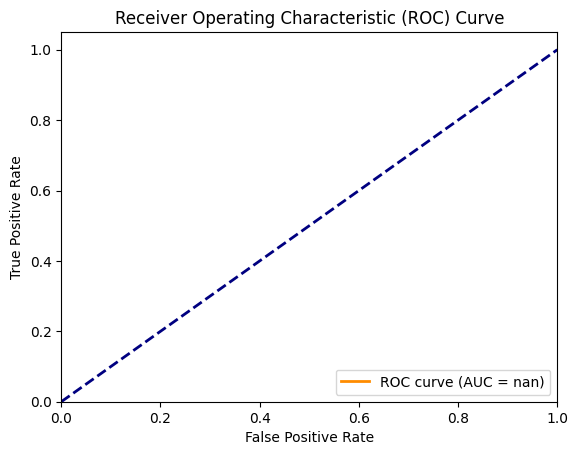

In [ ]:
plt.figure()
plt.plot(fpr_3_5_turbo_main_part, tpr_3_5_turbo_main_part, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_3_5_turbo_main_part)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

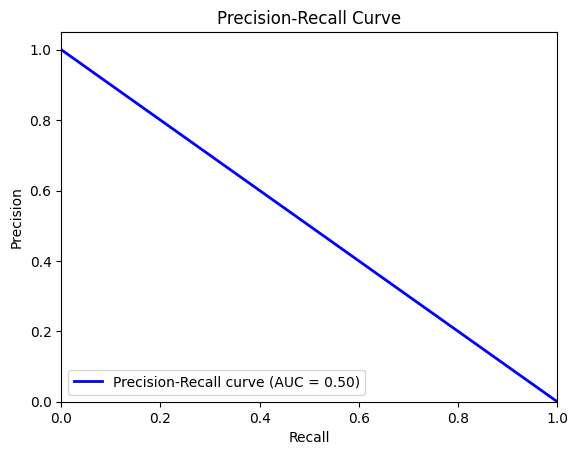

In [ ]:
plt.figure()
plt.plot(recall_3_5_turbo_main_part, precision_3_5_turbo_main_part, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc_3_5_turbo_main_part)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

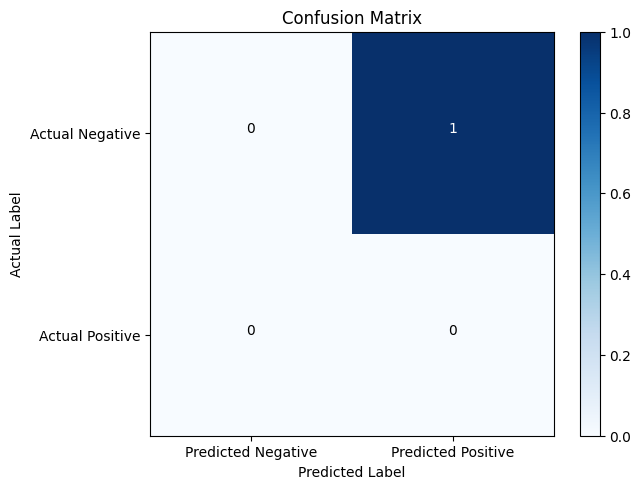

In [ ]:
plt.figure()
plt.imshow(conf_matrix_3_5_turbo_main_part, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])

thresh = conf_matrix_3_5_turbo_main_part.max() / 2.
for i in range(conf_matrix_3_5_turbo_main_part.shape[0]):
    for j in range(conf_matrix_3_5_turbo_main_part.shape[1]):
        plt.text(j, i, format(conf_matrix_3_5_turbo_main_part[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_3_5_turbo_main_part[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

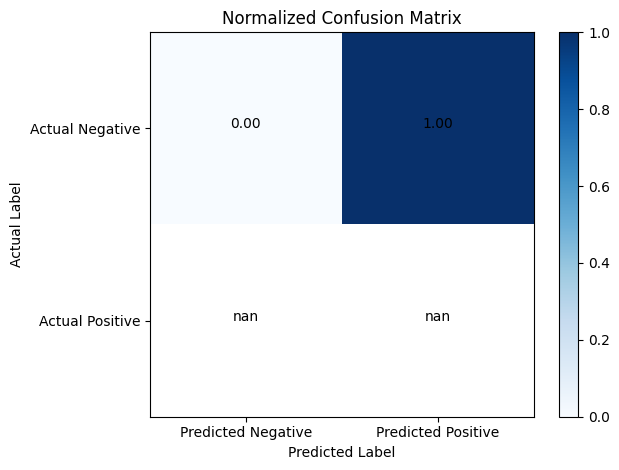

In [ ]:
plt.figure()
plt.imshow(conf_matrix_norm_3_5_turbo_main_part, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
thresh = conf_matrix_norm_3_5_turbo_main_part.max() / 2.
for i in range(conf_matrix_norm_3_5_turbo_main_part.shape[0]):
    for j in range(conf_matrix_norm_3_5_turbo_main_part.shape[1]):
        plt.text(j, i, format(conf_matrix_norm_3_5_turbo_main_part[i, j], '.2f'),
                 horizontalalignment='center',
                 color='white' if conf_matrix_norm_3_5_turbo_main_part[i, j] > thresh else 'black')
plt.tight_layout()
plt.show()


#### For Benefit Redundancy

In [ ]:
ground_truth_3_5_turbo_benefit: np.array
predicted_redundancy_3_5_turbo_benefit: np.array
tp_3_5_turbo_benefit: int = 0
fp_3_5_turbo_benefit: int = 0
tn_3_5_turbo_benefit: int = 0
fn_3_5_turbo_benefit: int = 0

In [ ]:
ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit, tp_3_5_turbo_benefit, fp_3_5_turbo_benefit, tn_3_5_turbo_benefit, fn_3_5_turbo_benefit = calc_benefit_redundancy(excel_data, chat_gpt_results['redundancy-model-gpt-3.5-turbo'])

In [ ]:
assert len(ground_truth_3_5_turbo_benefit) == len(predicted_redundancy_3_5_turbo_benefit)
print("Ground Truth:", ground_truth_3_5_turbo_benefit)
print("Predicted:", predicted_redundancy_3_5_turbo_benefit)
print("True Positives (TP):", tp_3_5_turbo_benefit)
print("False Positives (FP):", fp_3_5_turbo_benefit)
print("True Negatives (TN):", tn_3_5_turbo_benefit)
print("False Negatives (FN):", fn_3_5_turbo_benefit)

Ground Truth: [1]
Predicted: [1]
True Positives (TP): 1
False Positives (FP): 0
True Negatives (TN): 0
False Negatives (FN): 0


In [ ]:
precision_3_5_turbo_benefit = precision_score(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit)
recall_3_5_turbo_benefit = recall_score(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit)
f1_3_5_turbo_benefit = f1_score(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit)
accuracy_3_5_turbo_benefit = accuracy_score(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit)

sensitivity_3_5_turbo_benefit = tp_3_5_turbo_benefit / (tp_3_5_turbo_benefit + fn_3_5_turbo_benefit + EPSILON) 
specificity_3_5_turbo_benefit = tn_3_5_turbo_benefit / (tn_3_5_turbo_benefit + fp_3_5_turbo_benefit + EPSILON)
fpr_manual_3_5_turbo_benefit = fp_3_5_turbo_benefit / (fp_3_5_turbo_benefit + tn_3_5_turbo_benefit + EPSILON)

#Confusion Matrix
conf_matrix_3_5_turbo_benefit = confusion_matrix(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit)
conf_matrix_norm_3_5_turbo_benefit = conf_matrix_3_5_turbo_benefit.astype('float') / conf_matrix_3_5_turbo_benefit.sum(axis=1)[:, np.newaxis]

#This is needed for plotting
fpr_3_5_turbo_benefit, tpr_3_5_turbo_benefit, thresholds_3_5_turbo_benefit = roc_curve(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit)
roc_auc_3_5_turbo_benefit = auc(fpr_3_5_turbo_main_part, tpr_3_5_turbo_main_part)

# Precision-Recall Curve and AUC-PR
precision_3_5_turbo_benefit, recall_3_5_turbo_benefit, __3_5_turbo_benefit = precision_recall_curve(ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit)
pr_auc_3_5_turbo_benefit = auc(recall_3_5_turbo_benefit, precision_3_5_turbo_benefit)

d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1137: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


In [ ]:
print("Precision:", precision_3_5_turbo_benefit)
print("Recall:",recall_3_5_turbo_benefit)
print("F1:",f1_3_5_turbo_benefit)
print("Accuracy:",accuracy_3_5_turbo_benefit)
print("Sensitivity:",sensitivity_3_5_turbo_benefit)
print("Specificity:",specificity_3_5_turbo_benefit)
print("False positive rate:", fpr_manual_3_5_turbo_benefit)
print("-" * 5)
print("Confusion Matrix:", conf_matrix_3_5_turbo_benefit)
print("Normalised Confusion Matrix:", conf_matrix_norm_3_5_turbo_benefit)
print("-" * 5)
print("AUC-ROC:", roc_auc_3_5_turbo_benefit)
print("AUC-PR:", pr_auc_3_5_turbo_benefit)

Precision: [1. 1.]
Recall: [1. 0.]
F1: 1.0
Accuracy: 1.0
Sensitivity: 1.0
Specificity: 0.0
False positive rate: 0.0
-----
Confusion Matrix: [[1]]
Normalised Confusion Matrix: [[1.]]
-----
AUC-ROC: nan
AUC-PR: 1.0


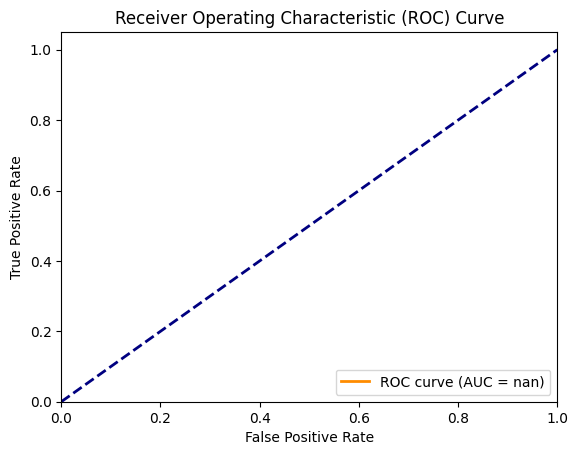

In [ ]:
plt.figure()
plt.plot(fpr_3_5_turbo_benefit, tpr_3_5_turbo_benefit, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_3_5_turbo_benefit)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

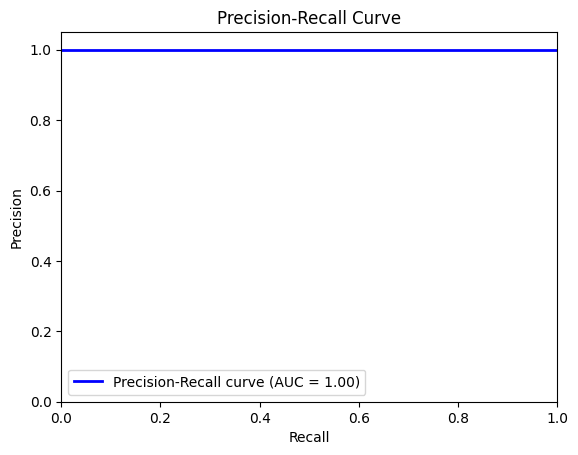

In [ ]:
plt.figure()
plt.plot(recall_3_5_turbo_benefit, precision_3_5_turbo_benefit, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc_3_5_turbo_benefit)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

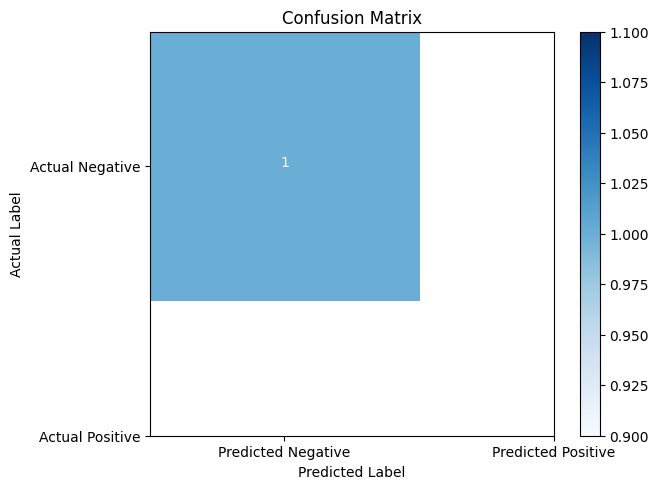

In [ ]:
plt.figure()
plt.imshow(conf_matrix_3_5_turbo_benefit, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])

thresh = conf_matrix_3_5_turbo_benefit.max() / 2.
for i in range(conf_matrix_3_5_turbo_benefit.shape[0]):
    for j in range(conf_matrix_3_5_turbo_benefit.shape[1]):
        plt.text(j, i, format(conf_matrix_3_5_turbo_benefit[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_3_5_turbo_benefit[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

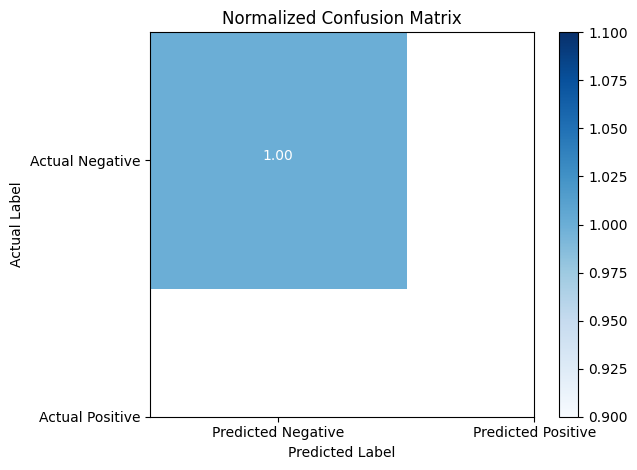

In [ ]:
plt.figure()
plt.imshow(conf_matrix_norm_3_5_turbo_benefit, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
thresh = conf_matrix_norm_3_5_turbo_benefit.max() / 2.
for i in range(conf_matrix_norm_3_5_turbo_benefit.shape[0]):
    for j in range(conf_matrix_norm_3_5_turbo_benefit.shape[1]):
        plt.text(j, i, format(conf_matrix_norm_3_5_turbo_benefit[i, j], '.2f'),
                 horizontalalignment='center',
                 color='white' if conf_matrix_norm_3_5_turbo_benefit[i, j] > thresh else 'black')
plt.tight_layout()
plt.show()

#### redundancy-model-gpt-4-turbo

#### Time Consumption

In [ ]:
total_time_per_file_4, avg_time_per_file_4, total_time_4, avg_time_4 = calc_time_consumption(chat_gpt_results['redundancy-model-gpt-4-turbo'])

#### For Main Part Redundancy (Full/Partial?)

In [ ]:
###Both was flatten based on the predicted dataset
ground_truth_4_turbo_main_part: np.array
predicted_redundancy_4_turbo_main_part: np.array
tp_4_turbo_main_part: int = 0
fp_4_turbo_main_part: int = 0
tn_4_turbo_main_part: int = 0
fn_4_turbo_main_part: int = 0

In [ ]:
ground_truth_4_turbo_main_part, predicted_redundancy_4_turbo_main_part, tp_4_turbo_main_part, fp_4_turbo_main_part, tn_4_turbo_main_part, fn_4_turbo_main_part = calc_main_part_redundancy(excel_data, chat_gpt_results['redundancy-model-gpt-4-turbo'])

In [ ]:
assert len(ground_truth_4_turbo_main_part) == len(predicted_redundancy_4_turbo_main_part)
print("Ground Truth:", ground_truth_4_turbo_main_part)
print("Predicted:", predicted_redundancy_4_turbo_main_part)
print("True Positives (TP):" ,tp_4_turbo_main_part)
print("False Positives (FP):", fp_4_turbo_main_part)
print("True Negatives (TN):", tn_4_turbo_main_part)
print("False Negatives (FN):", fn_4_turbo_main_part)

Ground Truth: [0]
Predicted: [1]
True Positives (TP): 0
False Positives (FP): 1
True Negatives (TN): 0
False Negatives (FN): 0


In [ ]:
precision_4_turbo_main_part = precision_score(ground_truth_4_turbo_main_part, predicted_redundancy_4_turbo_main_part)
recall_4_turbo_main_part = recall_score(ground_truth_4_turbo_main_part, predicted_redundancy_4_turbo_main_part)
f1_4_turbo_main_part = f1_score(ground_truth_4_turbo_main_part, predicted_redundancy_4_turbo_main_part)
accuracy_4_turbo_main_part = accuracy_score(ground_truth_4_turbo_main_part, predicted_redundancy_4_turbo_main_part)

sensitivity_4_turbo_main_part = tp_4_turbo_main_part / (tp_4_turbo_main_part + fn_4_turbo_main_part + EPSILON) 
specificity_4_turbo_main_part = tn_4_turbo_main_part / (tn_4_turbo_main_part + fp_4_turbo_main_part + EPSILON)
fpr_manual_4_turbo_main_part = fp_4_turbo_main_part / (fp_4_turbo_main_part + tn_4_turbo_main_part + EPSILON)

#Confusion Matrix
conf_matrix_4_turbo_main_part = confusion_matrix(ground_truth_4_turbo_main_part, predicted_redundancy_4_turbo_main_part)
conf_matrix_norm_4_turbo_main_part = conf_matrix_4_turbo_main_part.astype('float') / conf_matrix_4_turbo_main_part.sum(axis=1)[:, np.newaxis]

#This is needed for plotting
fpr_4_turbo_main_part, tpr_4_turbo_main_part, thresholds_4_turbo_main_part = roc_curve(ground_truth_4_turbo_main_part, predicted_redundancy_4_turbo_main_part)
roc_auc_4_turbo_main_part = auc(fpr_4_turbo_main_part, tpr_4_turbo_main_part)

# Precision-Recall Curve and AUC-PR
precision_4_turbo_main_part, recall_4_turbo_main_part, __4_turbo_main_part = precision_recall_curve(ground_truth_4_turbo_main_part, predicted_redundancy_4_turbo_main_part)
pr_auc_4_turbo_main_part = auc(recall_4_turbo_main_part, precision_4_turbo_main_part)


d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lukas Hofmann\AppData\Local\Temp\ipykernel_24900\39702669.py:12: RuntimeWarning: invalid value encountered in divide
  conf_matrix_norm_4_turbo_main_part = conf_matrix_4_turbo_main_part.astype('float') / conf_matrix_4_turbo_main_part.sum(axis=1)[:, np.newaxis]
d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, rec

In [ ]:
print("Precision:", precision_4_turbo_main_part)
print("Recall:",recall_4_turbo_main_part)
print("F1:",f1_4_turbo_main_part)
print("Accuracy:",accuracy_4_turbo_main_part)
print("Sensitivity:",sensitivity_4_turbo_main_part)
print("Specificity:",specificity_4_turbo_main_part)
print("False positive rate:", fpr_manual_4_turbo_main_part)
print("-" * 5)
print("Confusion Matrix:", conf_matrix_4_turbo_main_part)
print("Normalised Confusion Matrix:", conf_matrix_norm_4_turbo_main_part)
print("-" * 5)
print("AUC-ROC:", roc_auc_4_turbo_main_part)
print("AUC-PR:", pr_auc_4_turbo_main_part)

Precision: [0. 1.]
Recall: [1. 0.]
F1: 0.0
Accuracy: 0.0
Sensitivity: 0.0
Specificity: 0.0
False positive rate: 1.0
-----
Confusion Matrix: [[0 1]
 [0 0]]
Normalised Confusion Matrix: [[ 0.  1.]
 [nan nan]]
-----
AUC-ROC: nan
AUC-PR: 0.5


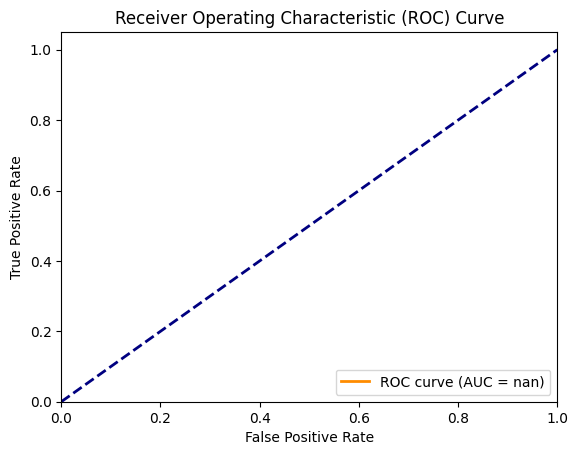

In [ ]:
plt.figure()
plt.plot(fpr_4_turbo_main_part, tpr_4_turbo_main_part, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_4_turbo_main_part)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

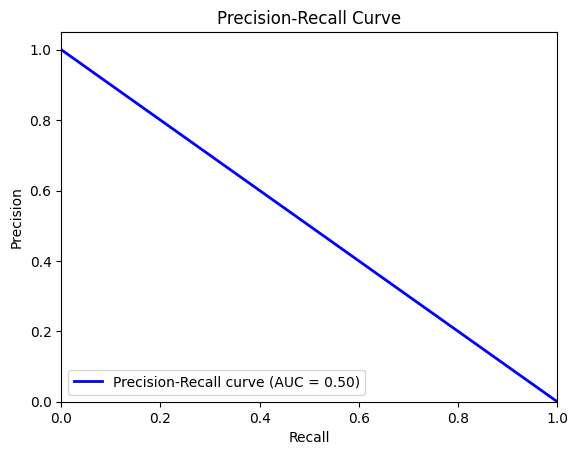

In [ ]:
plt.figure()
plt.plot(recall_4_turbo_main_part, precision_4_turbo_main_part, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc_4_turbo_main_part)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

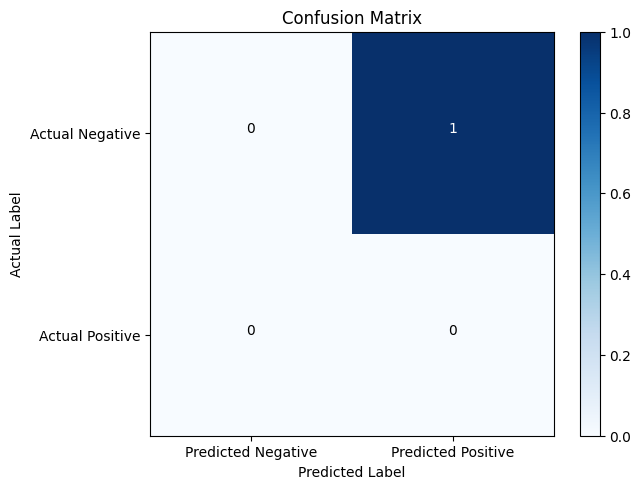

In [ ]:
plt.figure()
plt.imshow(conf_matrix_4_turbo_main_part, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])

thresh = conf_matrix_4_turbo_main_part.max() / 2.
for i in range(conf_matrix_4_turbo_main_part.shape[0]):
    for j in range(conf_matrix_4_turbo_main_part.shape[1]):
        plt.text(j, i, format(conf_matrix_4_turbo_main_part[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_4_turbo_main_part[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

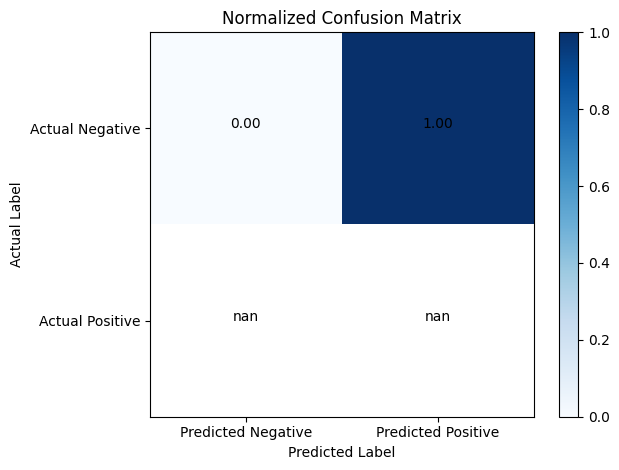

In [ ]:
plt.figure()
plt.imshow(conf_matrix_norm_4_turbo_main_part, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
thresh = conf_matrix_norm_4_turbo_main_part.max() / 2.
for i in range(conf_matrix_norm_4_turbo_main_part.shape[0]):
    for j in range(conf_matrix_norm_4_turbo_main_part.shape[1]):
        plt.text(j, i, format(conf_matrix_norm_4_turbo_main_part[i, j], '.2f'),
                 horizontalalignment='center',
                 color='white' if conf_matrix_norm_4_turbo_main_part[i, j] > thresh else 'black')
plt.tight_layout()
plt.show()


#### For Benefit Redundancy

In [ ]:
ground_truth_4_turbo_benefit: np.array
predicted_redundancy_4_turbo_benefit: np.array
tp_4_turbo_benefit: int = 0
fp_4_turbo_benefit: int = 0
tn_4_turbo_benefit: int = 0
fn_4_turbo_benefit: int = 0

In [ ]:
ground_truth_4_turbo_benefit, predicted_redundancy_4_turbo_benefit, tp_4_turbo_benefit, fp_4_turbo_benefit, tn_4_turbo_benefit, fn_4_turbo_benefit = calc_benefit_redundancy(excel_data, chat_gpt_results['redundancy-model-gpt-4-turbo'])

In [ ]:
assert len(ground_truth_4_turbo_benefit) == len(predicted_redundancy_4_turbo_benefit)
print("Ground Truth:",ground_truth_4_turbo_benefit)
print("Predicted:",predicted_redundancy_4_turbo_benefit)
print("True Positives (TP):", tp_4_turbo_benefit)
print("False Positives (FP):", fp_4_turbo_benefit)
print("True Negatives (TN):", tn_4_turbo_benefit)
print("False Negatives (FN):", fn_4_turbo_benefit)

Ground Truth: [0]
Predicted: [1]
True Positives (TP): 0
False Positives (FP): 1
True Negatives (TN): 0
False Negatives (FN): 0


In [ ]:
precision_4_turbo_benefit = precision_score(ground_truth_4_turbo_benefit, predicted_redundancy_4_turbo_benefit)
recall_4_turbo_benefit = recall_score(ground_truth_4_turbo_benefit, predicted_redundancy_4_turbo_benefit)
f1_4_turbo_benefit = f1_score(ground_truth_4_turbo_benefit, predicted_redundancy_4_turbo_benefit)
accuracy_4_turbo_benefit = accuracy_score(ground_truth_4_turbo_benefit, predicted_redundancy_4_turbo_benefit)

sensitivity_4_turbo_benefit = tp_4_turbo_benefit / (tp_4_turbo_benefit + fn_4_turbo_benefit + EPSILON) 
specificity_4_turbo_benefit = tn_4_turbo_benefit / (tn_3_5_turbo_benefit + fp_4_turbo_benefit + EPSILON)
fpr_manual_4_turbo_benefit = fp_4_turbo_benefit / (fp_4_turbo_benefit + tn_4_turbo_benefit + EPSILON)

#Confusion Matrix
conf_matrix_4_turbo_benefit = confusion_matrix(ground_truth_4_turbo_benefit, predicted_redundancy_4_turbo_benefit)
conf_matrix_norm_4_turbo_benefit = conf_matrix_4_turbo_benefit.astype('float') / conf_matrix_4_turbo_benefit.sum(axis=1)[:, np.newaxis]

#This is needed for plotting
fpr_4_turbo_benefit, tpr_4_turbo_benefit, thresholds_4_turbo_benefit = roc_curve(ground_truth_4_turbo_benefit, predicted_redundancy_4_turbo_benefit)
roc_auc_4_turbo_benefit = auc(fpr_4_turbo_main_part, tpr_4_turbo_main_part)

# Precision-Recall Curve and AUC-PR
precision_4_turbo_benefit, recall_4_turbo_benefit, __4_turbo_benefit = precision_recall_curve(ground_truth_4_turbo_benefit, predicted_redundancy_4_turbo_benefit)
pr_auc_4_turbo_benefit = auc(recall_4_turbo_benefit, precision_4_turbo_benefit)

d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lukas Hofmann\AppData\Local\Temp\ipykernel_24900\4239213768.py:12: RuntimeWarning: invalid value encountered in divide
  conf_matrix_norm_4_turbo_benefit = conf_matrix_4_turbo_benefit.astype('float') / conf_matrix_4_turbo_benefit.sum(axis=1)[:, np.newaxis]
d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
d:\_Projects\_myProjects\RedundancyAndConflictAnalysis\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall 

In [ ]:
print("Precision:", precision_4_turbo_benefit)
print("Recall:",recall_4_turbo_benefit)
print("F1:",f1_3_5_turbo_benefit)
print("Accuracy:",accuracy_4_turbo_benefit)
print("Sensitivity:",sensitivity_4_turbo_benefit)
print("Specificity:",specificity_4_turbo_benefit)
print("False positive rate:", fpr_manual_4_turbo_benefit)
print("-" * 5)
print("Confusion Matrix:", conf_matrix_4_turbo_benefit)
print("Normalised Confusion Matrix:", conf_matrix_norm_4_turbo_benefit)
print("-" * 5)
print("AUC-ROC:", roc_auc_4_turbo_benefit)
print("AUC-PR:", pr_auc_4_turbo_benefit)

Precision: [0. 1.]
Recall: [1. 0.]
F1: 1.0
Accuracy: 0.0
Sensitivity: 0.0
Specificity: 0.0
False positive rate: 1.0
-----
Confusion Matrix: [[0 1]
 [0 0]]
Normalised Confusion Matrix: [[ 0.  1.]
 [nan nan]]
-----
AUC-ROC: nan
AUC-PR: 0.5


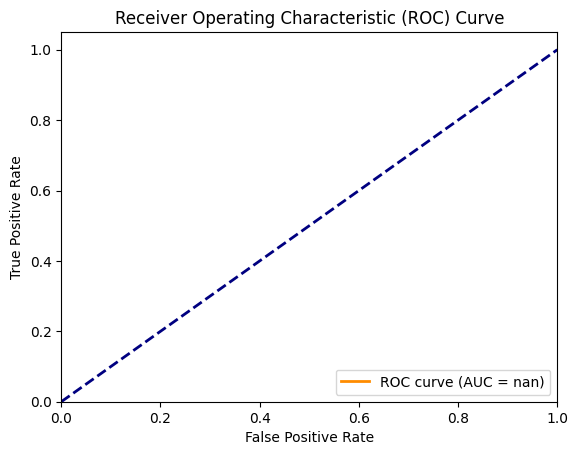

In [ ]:
plt.figure()
plt.plot(fpr_4_turbo_benefit, tpr_4_turbo_benefit, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_4_turbo_benefit)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

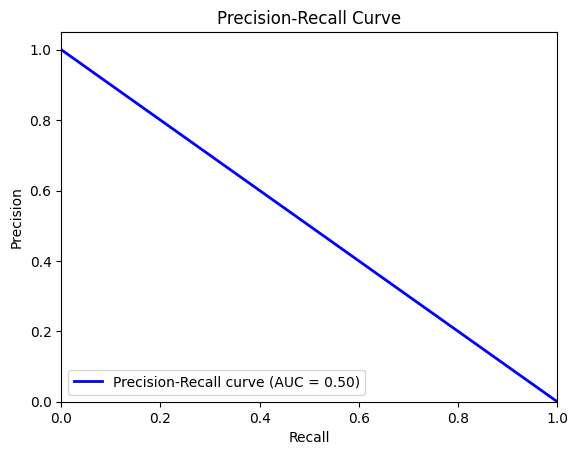

In [ ]:
plt.figure()
plt.plot(recall_4_turbo_benefit, precision_4_turbo_benefit, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc_4_turbo_benefit)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

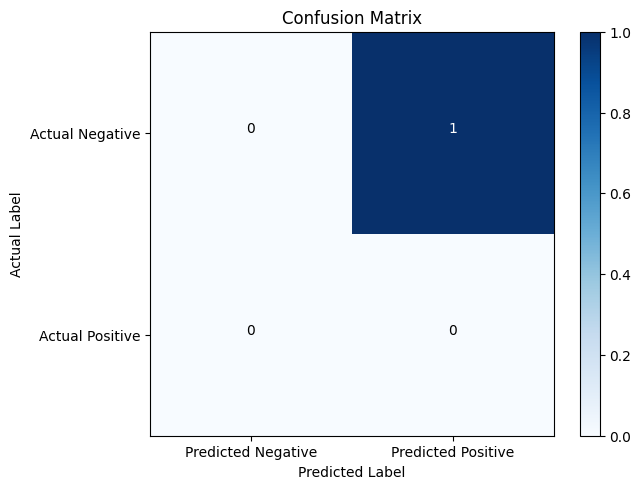

In [ ]:
plt.figure()
plt.imshow(conf_matrix_4_turbo_benefit, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])

thresh = conf_matrix_4_turbo_benefit.max() / 2.
for i in range(conf_matrix_4_turbo_benefit.shape[0]):
    for j in range(conf_matrix_4_turbo_benefit.shape[1]):
        plt.text(j, i, format(conf_matrix_4_turbo_benefit[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_4_turbo_benefit[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

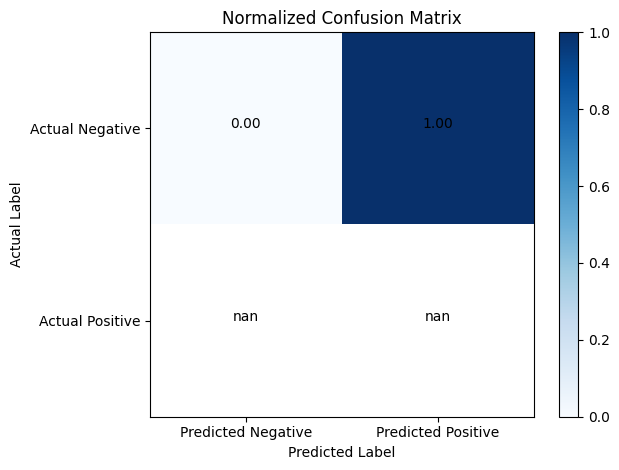

In [ ]:
plt.figure()
plt.imshow(conf_matrix_norm_4_turbo_benefit, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
thresh = conf_matrix_norm_4_turbo_benefit.max() / 2.
for i in range(conf_matrix_norm_4_turbo_benefit.shape[0]):
    for j in range(conf_matrix_norm_4_turbo_benefit.shape[1]):
        plt.text(j, i, format(conf_matrix_norm_4_turbo_benefit[i, j], '.2f'),
                 horizontalalignment='center',
                 color='white' if conf_matrix_norm_4_turbo_benefit[i, j] > thresh else 'black')
plt.tight_layout()
plt.show()

### Combinded ROC and PRC Curve

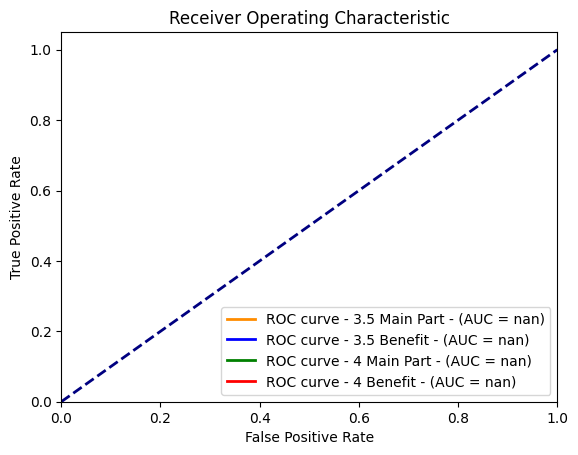

In [ ]:
plt.figure()

plt.plot(fpr_4_turbo_benefit, tpr_4_turbo_benefit, color='darkorange', lw=2, label='ROC curve - 3.5 Main Part - (AUC = %0.2f)' % roc_auc_4_turbo_benefit)
plt.plot(fpr_3_5_turbo_benefit, tpr_3_5_turbo_benefit, color='blue', lw=2, label='ROC curve - 3.5 Benefit - (AUC = %0.2f)' % roc_auc_3_5_turbo_benefit)
plt.plot(fpr_4_turbo_main_part, tpr_4_turbo_main_part, color='green', lw=2, label='ROC curve - 4 Main Part - (AUC = %0.2f)' % roc_auc_4_turbo_main_part)
plt.plot(fpr_4_turbo_benefit, tpr_4_turbo_benefit, color='red', lw=2, label='ROC curve - 4 Benefit - (AUC = %0.2f)' % roc_auc_4_turbo_benefit)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

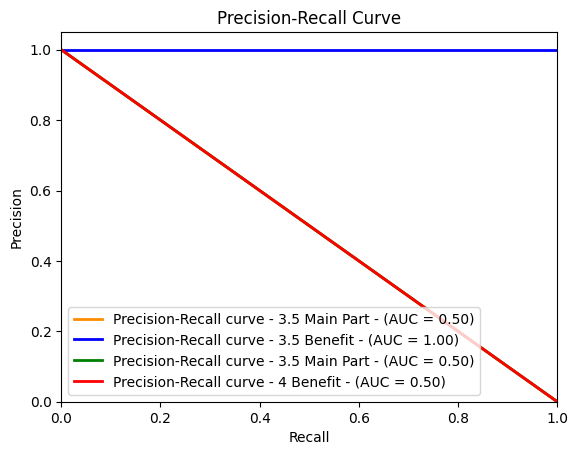

In [ ]:
plt.figure()

plt.plot(recall_3_5_turbo_main_part, precision_3_5_turbo_main_part, color='darkorange', lw=2, label='Precision-Recall curve - 3.5 Main Part - (AUC = %0.2f)' % pr_auc_3_5_turbo_main_part)
plt.plot(recall_3_5_turbo_benefit, precision_3_5_turbo_benefit, color='blue', lw=2, label='Precision-Recall curve - 3.5 Benefit - (AUC = %0.2f)' % pr_auc_3_5_turbo_benefit)
plt.plot(recall_4_turbo_main_part, precision_4_turbo_main_part, color='green', lw=2, label='Precision-Recall curve - 3.5 Main Part - (AUC = %0.2f)' % pr_auc_4_turbo_main_part)
plt.plot(recall_4_turbo_benefit, precision_4_turbo_benefit, color='red', lw=2, label='Precision-Recall curve - 4 Benefit - (AUC = %0.2f)' % pr_auc_4_turbo_benefit)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Prepaire Dataframe with Resutls

In [ ]:
def get_colomuns_metrics() -> list[str]: 
    return [
        'Model', 'Redundancy Part',
        'Ground Truth', 'Predicted', 'True Positives', 'False Positives', 
        'True Negatives', 'False Negatives', 'Precision', 'Recall', 
        'F1 Score', 'Accuracy', 'Sensitivity', 'Specificity', 'False Positive Rate'
    ]

def add_metrics_row(df: pd.DataFrame, model, redundancy_part, ground_truth, predicted, tp, fp, tn, fn, precision, recall, f1_score, accuracy, sensitivity, specificity, fpr):
    n_a2s = np.array2string
    new_row = pd.DataFrame({
        'Model': [model], 
        'Redundancy Part': [redundancy_part],
        'Ground Truth': [n_a2s(ground_truth)], 
        'Predicted': [n_a2s(predicted)], 
        'True Positives': [tp], 
        'False Positives': [fp], 
        'True Negatives': [tn], 
        'False Negatives': [fn], 
        'Precision': [n_a2s(precision)], 
        'Recall': [n_a2s(recall)],
        'F1 Score': [n_a2s(f1_score)], 
        'Accuracy': [accuracy], 
        'Sensitivity': [sensitivity], 
        'Specificity': [specificity], 
        'False Positive Rate': [fpr]
    })
    return pd.concat([df, new_row], ignore_index=True)

def create_metrics_dataframe() -> pd.DataFrame:
    lv_metrics_df = pd.DataFrame(columns=get_colomuns_metrics())
    lv_metrics_df = add_metrics_row(lv_metrics_df, "ChatGPT 3.5 Turbo", "Main Part",
                                    ground_truth_3_5_turbo_main_part, predicted_redundancy_3_5_turbo_main_part, tp_3_5_turbo_main_part, fp_3_5_turbo_main_part, tn_3_5_turbo_main_part, fn_3_5_turbo_main_part, precision_3_5_turbo_main_part, 
                                    recall_3_5_turbo_main_part, f1_3_5_turbo_main_part, accuracy_3_5_turbo_main_part, sensitivity_3_5_turbo_main_part, specificity_3_5_turbo_main_part, fpr_manual_3_5_turbo_main_part)
    
    lv_metrics_df = add_metrics_row(lv_metrics_df, "ChatGPT 3.5 Turbo", "Benefit",
                                    ground_truth_3_5_turbo_benefit, predicted_redundancy_3_5_turbo_benefit, tp_3_5_turbo_benefit, fp_3_5_turbo_benefit, tn_3_5_turbo_benefit, fn_3_5_turbo_benefit, precision_3_5_turbo_benefit,
                                    recall_3_5_turbo_benefit, f1_3_5_turbo_benefit, accuracy_3_5_turbo_benefit, sensitivity_3_5_turbo_benefit, specificity_3_5_turbo_benefit, fpr_manual_3_5_turbo_benefit)
    
    lv_metrics_df = add_metrics_row(lv_metrics_df, "ChatGPT 4 Turbo", "Main Part",
                                    ground_truth_4_turbo_main_part, predicted_redundancy_4_turbo_main_part, tp_4_turbo_main_part, fp_4_turbo_main_part, tn_4_turbo_main_part, fn_4_turbo_main_part, precision_4_turbo_main_part,
                                    recall_4_turbo_main_part, f1_4_turbo_main_part, accuracy_4_turbo_main_part, sensitivity_4_turbo_main_part, specificity_4_turbo_main_part, fpr_manual_4_turbo_main_part)
    
    lv_metrics_df = add_metrics_row(lv_metrics_df, "ChatGPT 4 Turbo", "Benefit",
                                    ground_truth_4_turbo_benefit, predicted_redundancy_4_turbo_benefit, tp_4_turbo_benefit, fp_4_turbo_benefit, tn_4_turbo_benefit, fn_4_turbo_benefit, precision_4_turbo_benefit,
                                    recall_4_turbo_benefit, f1_4_turbo_benefit, accuracy_4_turbo_benefit, sensitivity_4_turbo_benefit, specificity_4_turbo_benefit, fpr_manual_4_turbo_benefit)
    return lv_metrics_df

In [ ]:
metrics_df: pd.DataFrame
metrics_df = create_metrics_dataframe() 
metrics_df.head(4)

C:\Users\Lukas Hofmann\AppData\Local\Temp\ipykernel_24900\1241735457.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, new_row], ignore_index=True)


,Model,Redundancy Part,Ground Truth,Predicted,True Positives,False Positives,True Negatives,False Negatives,Precision,Recall,F1 Score,Accuracy,Sensitivity,Specificity,False Positive Rate
0,ChatGPT 3.5 Turbo,Main Part,[0],[1],0,0,0,0,[0. 1.],[1. 0.],0.,0.0,0.0,0.0,0.0
1,ChatGPT 3.5 Turbo,Benefit,[1],[1],1,0,0,0,[1. 1.],[1. 0.],1.,1.0,1.0,0.0,0.0
2,ChatGPT 4 Turbo,Main Part,[0],[1],0,1,0,0,[0. 1.],[1. 0.],0.,0.0,0.0,0.0,1.0
3,ChatGPT 4 Turbo,Benefit,[0],[1],0,1,0,0,[0. 1.],[1. 0.],0.,0.0,0.0,0.0,1.0


## Analysing the Datasets for finding the false positives and false negatives and storing into an .xlsx file
This part can be used for further human analyses to determine for where the difference of the formal tool and ChatGPT chatbot is.

In [ ]:
def split_and_remove_prefix(snippet: pd.DataFrame) -> tuple[int, int]:
    PATTERN = r'^user_story_\d+: #\w+#'
    formal_text_one, formal_text_two = (snippet.iloc[0]['User Stories Texts']).split("\n\n")
    formal_text_one = re.sub(PATTERN, '', formal_text_one)
    formal_text_two = re.sub(PATTERN, '', formal_text_two)
    return formal_text_one, formal_text_two

def collecting_reasons_and_references(items: list) -> tuple[str, str, str]:
    reason_describtions:str = ""
    reference_to_original_text_one:str  = ""
    reference_to_original_text_two:str = ""
    for idx, item in enumerate(items):
        reason_describtions += f'{idx}.) {item['reasonDescribtion']}\n'
        reference_to_original_text_one += f'{idx}.) {item['referenceToOriginalText'][0]}\n\n'
        reference_to_original_text_two += f'{idx}.) {item['referenceToOriginalText'][1]}\n\n'
    return reason_describtions, reference_to_original_text_one, reference_to_original_text_two

def raise_if_duplicated_usid_in_original_data(n: int, s1: str, s2: str):
    raise Exception(f'The User Story {n} appears at last twice. Once in {s1} and second in {s2}.')

def collect_original_text_pairs(ORIGINAL_DATASET: dict, usidone: int, usidtwo: int, original_text_one: str, original_text_two: str) -> tuple[str, str]:
    original_text_one_found_in: str = ''
    original_text_two_found_in: str = ''
    for key, values in ORIGINAL_DATASET.items():
        for value in values:
            if (value['id'] == usidone):
                if original_text_one:
                    raise_if_duplicated_usid_in_original_data(value['id'], original_text_one_found_in, key)
                original_text_one = value['text']
                original_text_one_found_in = key
            if (value['id'] == usidtwo):
                if original_text_two:
                    raise_if_duplicated_usid_in_original_data(value['id'], original_text_two_found_in, key)
                original_text_two = value['text']
                original_text_two_found_in = key
    if not original_text_one:
        original_text_one = "No text found in source"               
    if not original_text_two:
        original_text_two = "No text found in source"
    return original_text_one, original_text_two

### Getting false positives and false negatives

In [ ]:
REDUNDANCY_CATEGORIES_FALSE_TYPE = ["False Positive", "False Negative"]
REDUNDANCY_CATEGORIES_MAIN_PART_BENEFIT = ["Main Part", "Benefit"]


DF_SHOW_FALSE_POSITIVES_NEGATIVES_DTYPES = {
    'Execution Run': 'int',
    'Model': 'str',
    'False Type': pd.CategoricalDtype(categories=REDUNDANCY_CATEGORIES_FALSE_TYPE),
    'Main Part or Benefit': pd.CategoricalDtype(categories=REDUNDANCY_CATEGORIES_MAIN_PART_BENEFIT),
    'User Story Id 1': 'int',
    'User Story Id 2': 'int',
    'Reason from ChatGPT': 'str',
    'Refered Text 1 by ChatGPT': 'str',
    'Refered Text 1 from formal Approach or Original Text in case of false positive': 'str',
    'Refered Text 2 by ChatGPT': 'str',
    'Refered Text 2 from formal Approach or Original Text in case of false positive': 'str'
}
df_show_false_positives_negatives = pd.DataFrame(columns=DF_SHOW_FALSE_POSITIVES_NEGATIVES_DTYPES.keys()).astype(dtype=DF_SHOW_FALSE_POSITIVES_NEGATIVES_DTYPES)

In [ ]:
def fill_df_show_false_positives_negatives(local_df_show_false_positives_negatives: pd.core.series.Series, model: str, chat_gpt_input_category: dict) -> pd.DataFrame:
    CATEGORY_FALSE_POSITIVE = "False Positive"
    CATEGORY_FALSE_NEGATIVE = "False Negative"
    CATEGORY_MAIN_PART = "Main Part"
    CATEGORY_BENEFIT = "Benefit"
    ORIGINAL_DATASET = load_datasets_add_line_counter()
    
    def add_row_to_show_false_positives(local_df_show_false_positives_negatives: pd.DataFrame, execution_run: int, model: str, false_type: str, main_or_benefit: str, usid_one: int, 
                                    usid_two: int, reason_chat: str, text_chat_one: str, text_chat_two: str, text_formal_one: str, text_formal_two: str) -> pd.DataFrame:
        new_row = pd.DataFrame({
            'Execution Run':[execution_run],
            'Model': [model],
            'False Type': pd.Categorical([false_type], categories=REDUNDANCY_CATEGORIES_FALSE_TYPE),
            'Main Part or Benefit': pd.Categorical([main_or_benefit], categories=REDUNDANCY_CATEGORIES_MAIN_PART_BENEFIT),
            'User Story Id 1': [usid_one],
            'User Story Id 2': [usid_two],
            'Reason from ChatGPT': [reason_chat],
            'Refered Text 1 by ChatGPT': [text_chat_one],
            'Refered Text 1 from formal Approach or Original Text in case of false positive': [text_chat_one],
            'Refered Text 2 by ChatGPT': [text_chat_two],
            'Refered Text 2 from formal Approach or Original Text in case of false positive': [text_formal_two]
        })
        return pd.concat([local_df_show_false_positives_negatives, new_row], ignore_index=True)
    
    original_text_one: str = ''
    original_text_two: str = ''
    usidone: int = 0
    usidtwo: int = 0
    run: int = 0
    
    for file in chat_gpt_input_category.values():
        file_content = file
        for item in file_content:
            # Collecting the informations from the .json-files
            reason_describtions_main_part, reference_to_original_text_one_main_part, reference_to_original_text_two_main_part = collecting_reasons_and_references(item['mainPartRedundancies'])
            reason_describtions_benefit, reference_to_original_text_one_benefit, reference_to_original_text_two_benefit = collecting_reasons_and_references(item['benefitRedundancies'])
            usidone = 0
            usidtwo = 0
            run = 0
            try:
                usidone: int = int(item['relatedStories'][0])
                usidtwo: int = int(item['relatedStories'][1])
                run: int = list(chat_gpt_input_category.keys())[0].split("_")[0].strip()
            except ValueError:
                raise Exception("Conversion failed: String did not contain a valid integer.")
            
            # Searching for the entry in the ground truth
            filtered_rows = excel_data[(excel_data['Corresponding USID 1'].astype(int) == int(item['relatedStories'][0])) 
                                        & (excel_data['Corresponding USID 2'].astype(int) == int(item['relatedStories'][1]))]
            if (filtered_rows.shape[0] == 1):
                # Collecting the informations from the ground truth
                formal_text_one, formal_text_two = split_and_remove_prefix(filtered_rows)
                
                if not bool(item['redundantMainPart']) and bool(excel_data.iat[0, 6]):
                    local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, run,
                                                                                               model, CATEGORY_FALSE_NEGATIVE, 
                                                                                               CATEGORY_MAIN_PART, usidone, usidtwo,
                                                                                               reason_describtions_main_part,
                                                                                               reference_to_original_text_one_main_part, 
                                                                                               reference_to_original_text_two_main_part, 
                                                                                               formal_text_one,
                                                                                               formal_text_two)
                if not bool(item['redundantBenefit']) and bool(excel_data.iat[0, 7]):
                    local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, run,
                                                                                               model, CATEGORY_FALSE_NEGATIVE, 
                                                                                               CATEGORY_BENEFIT, usidone, usidtwo,
                                                                                               reason_describtions_benefit,
                                                                                               reference_to_original_text_one_benefit, 
                                                                                               reference_to_original_text_two_benefit, 
                                                                                               formal_text_one,
                                                                                               formal_text_two)
            elif (filtered_rows.shape[0] >= 2):
                raise Exception("There are more than or equal to 2 filtered rows.\n" + f"JSON File: {item}\n" + f"Excel{filtered_rows}")
            else:
                # Searching for the original text in the original data
                original_text_one = ''
                original_text_two = ''
                original_text_one, original_text_two = collect_original_text_pairs(ORIGINAL_DATASET, usidone, usidtwo, original_text_one, original_text_two)
                
                #Searching for the false positives. Thus, the reveresed case is also check.
                if bool(item['redundantMainPart']):
                    local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, run,
                                                                                               model, CATEGORY_FALSE_POSITIVE, 
                                                                                               CATEGORY_MAIN_PART, usidone, usidtwo,
                                                                                               reason_describtions_main_part,
                                                                                               reference_to_original_text_one_main_part, 
                                                                                               reference_to_original_text_two_main_part, 
                                                                                               original_text_two,
                                                                                               original_text_two)                
                if bool(item['redundantBenefit']):
                        local_df_show_false_positives_negatives = add_row_to_show_false_positives(local_df_show_false_positives_negatives, run,
                                                                                                model, CATEGORY_FALSE_POSITIVE, 
                                                                                                CATEGORY_BENEFIT, usidone, usidtwo,
                                                                                                reason_describtions_benefit,
                                                                                                reference_to_original_text_one_benefit, 
                                                                                                reference_to_original_text_two_benefit, 
                                                                                                original_text_two,
                                                                                                original_text_two)
    return local_df_show_false_positives_negatives

In [ ]:
df_show_false_positives_negatives = df_show_false_positives_negatives.drop(df_show_false_positives_negatives.index)
for key in chat_gpt_result_keys: 
    show_false_positives = chat_gpt_results[key]
    match = re.search(r'gpt.*$', key)
    df_show_false_positives_negatives = fill_df_show_false_positives_negatives(df_show_false_positives_negatives, match.group(), show_false_positives)
df_show_false_positives_negatives.head(5)

,Execution Run,Model,False Type,Main Part or Benefit,User Story Id 1,User Story Id 2,Reason from ChatGPT,Refered Text 1 by ChatGPT,Refered Text 1 from formal Approach or Original Text in case of false positive,Refered Text 2 by ChatGPT,Refered Text 2 from formal Approach or Original Text in case of false positive
0,00,gpt-4-turbo,False Positive,Main Part,590,591,0.) Dummy Value Describtion\n1.) The redundanc...,"0.) As a User, I want to verify myself\n\n1.) ...","0.) As a User, I want to verify myself\n\n1.) ...","0.) As an application User, I want to verify t...","As a developer, I want to have the subdomain b..."
1,00,gpt-4-turbo,False Positive,Benefit,590,591,0.) The redundancy in these sentences lies in ...,0.) I can login into the webpage.\n\n1.) I can...,0.) I can login into the webpage.\n\n1.) I can...,0.) I could login into the website\n\n1.) I ca...,"As a developer, I want to have the subdomain b..."


### Getting the true positives

In [ ]:
DF_SHOW_TRUE_POSITIVES_DTYPES = {
    'Execution Run': 'int',
    'Model': 'str',
    'Main Part or Benefit': pd.CategoricalDtype(categories=REDUNDANCY_CATEGORIES_MAIN_PART_BENEFIT),
    'User Story Id 1': 'int',
    'User Story Id 2': 'int',
    'Reason from ChatGPT': 'str',
    'Refered Text 1 by ChatGPT': 'str',
    'Refered Text 1 from formal Approach': 'str',
    'Refered Text 2 by ChatGPT': 'str',
    'Refered Text 2 from formal Approach': 'str'
}
df_show_true_positives = pd.DataFrame(columns=DF_SHOW_TRUE_POSITIVES_DTYPES.keys()).astype(dtype=DF_SHOW_TRUE_POSITIVES_DTYPES)

In [ ]:
def fill_df_show_true_positives(local_df_show_true_positives: pd.core.series.Series, model: str, chat_gpt_input_category: dict) -> pd.DataFrame:
    CATEGORY_MAIN_PART = "Main Part"
    CATEGORY_BENEFIT = "Benefit"
    
    def add_row_to_show_true_positives(local_df_show_true_positives: pd.DataFrame, execution_run: int, model: str, main_or_benefit: str, usid_one: int, 
                                    usid_two: int, reason_chat: str, text_chat_one: str, text_chat_two: str, text_formal_one: str, text_formal_two: str) -> pd.DataFrame:
        new_row = pd.DataFrame({
            'Execution Run':[execution_run],
            'Model': [model],
            'Main Part or Benefit': pd.Categorical([main_or_benefit], categories=REDUNDANCY_CATEGORIES_MAIN_PART_BENEFIT),
            'User Story Id 1': [usid_one],
            'User Story Id 2': [usid_two],
            'Reason from ChatGPT': [reason_chat],
            'Refered Text 1 by ChatGPT': [text_chat_one],
            'Refered Text 1 from formal Approach': [text_formal_one],
            'Refered Text 2 by ChatGPT': [text_chat_two],
            'Refered Text 2 from formal Approach': [text_formal_two]
        })
        return pd.concat([local_df_show_true_positives, new_row], ignore_index=True)
    
    for file in chat_gpt_input_category.values():
        file_content = file
        for item in file_content:
            filtered_rows = excel_data[(excel_data['Corresponding USID 1'].astype(int) == int(item['relatedStories'][0])) 
                                        & (excel_data['Corresponding USID 2'].astype(int) == int(item['relatedStories'][1]))]
            if (filtered_rows.shape[0] == 1):
                formal_text_one, formal_text_two = split_and_remove_prefix(filtered_rows)
                reason_describtions_main_part, reference_to_original_text_one_main_part, reference_to_original_text_two_main_part = collecting_reasons_and_references(item['benefitRedundancies'])
                reason_describtions_benefit, reference_to_original_text_one_benefit, reference_to_original_text_two_benefit = collecting_reasons_and_references(item['benefitRedundancies'])
                usidone: int = 0
                usidtwo: int = 0
                run: int = 0
                try:
                    usidone: int = int(item['relatedStories'][0])
                    usidtwo: int = int(item['relatedStories'][1])
                    run: int = list(chat_gpt_input_category.keys())[0].split("_")[0].strip()
                except ValueError:
                    raise Exception("Conversion failed: String did not contain a valid integer.")
                
                #Searching for the true positives for main part and benefit.
                if bool(item['redundantMainPart']) and bool(excel_data.iat[0, 6]):
                    local_df_show_true_positives = add_row_to_show_true_positives(local_df_show_true_positives, run,
                                                                                               model, CATEGORY_MAIN_PART, usidone, usidtwo,
                                                                                               reason_describtions_main_part,
                                                                                               reference_to_original_text_one_main_part, 
                                                                                               reference_to_original_text_two_main_part, 
                                                                                               formal_text_one,
                                                                                               formal_text_two)
                    
                if bool(item['redundantBenefit']) and bool(excel_data.iat[0, 7]):
                    local_df_show_true_positives = add_row_to_show_true_positives(local_df_show_true_positives, run,
                                                                                               model, CATEGORY_BENEFIT, usidone, usidtwo,
                                                                                               reason_describtions_benefit,
                                                                                               reference_to_original_text_one_benefit, 
                                                                                               reference_to_original_text_two_benefit, 
                                                                                               formal_text_one,
                                                                                               formal_text_two)
            elif (filtered_rows.shape[0] >= 2):
                raise Exception(f"There are more than or equal to 2 filtered rows.\n JSON File: {item}\n Excel{filtered_rows}")
    return local_df_show_true_positives

In [ ]:
df_show_true_positives = df_show_true_positives.drop(df_show_true_positives.index)
for key in chat_gpt_result_keys: 
    show_true_positives: dict = chat_gpt_results[key]
    match = re.search(r'gpt.*$', key)
    df_show_true_positives = fill_df_show_true_positives(df_show_true_positives, match.group(), show_true_positives)
df_show_true_positives.head(5)

,Execution Run,Model,Main Part or Benefit,User Story Id 1,User Story Id 2,Reason from ChatGPT,Refered Text 1 by ChatGPT,Refered Text 1 from formal Approach,Refered Text 2 by ChatGPT,Refered Text 2 from formal Approach
0,00,gpt-3.5-turbo,Benefit,326,353,0.) The redundancy in these sentences lies in ...,0.) I can login into the webpage.\n\n1.) I can...,"as a staff member, i want to assign an applic...",0.) I could login into the website\n\n1.) I ca...,"as a plan review staff member, i want to revi..."


### Saving the data results

In [ ]:
## Formatter metric
def formatter_metric(wb: Workbook, sheet_name: str): 
    ws: Worksheet = wb[sheet_name]
    header_font = Font(size=14, bold=True)
    for cell in ws["1:1"]:
        cell.font = header_font
    
    ADDITIONAL_LENGTH: int = 0
    ADJUSTED_WIDTH: int = 0
    MAX_LEN: int = 0
    for col in ws.iter_cols(min_row=1, max_row=1):
        for cell in col:
            MAX_LEN = len(str(cell.value))
            ADDITIONAL_LENGTH = (MAX_LEN + 2)
            ADJUSTED_WIDTH = 0
            if cell.col_idx == 1 or cell.col_idx == 2 or cell.col_idx == 3 or cell.col_idx == 12:
                ADJUSTED_WIDTH =  ADDITIONAL_LENGTH * 1.5
            else:
                ADJUSTED_WIDTH = ADDITIONAL_LENGTH * 1.2
            ws.column_dimensions[utils_get_column_letter(cell.column)].width = ADJUSTED_WIDTH
            
    alignment = Alignment(vertical='center', horizontal='left')
    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = alignment

    num_columns = ws.max_column
    header_range = f"A1:{utils_get_column_letter(num_columns)}1"
    ws.auto_filter.ref = header_range
    ws.freeze_panes = ws['A2']

    wrap_alignment = Alignment(wrap_text=True, vertical='top', horizontal='left')
    for row in ws.iter_rows(min_row=2):
        for cell in row:
            cell.alignment = wrap_alignment

In [ ]:
save_to_excel(metrics_df, formatter_metric, 'Only US-Result')

In [ ]:
## Formatter False Positives, False Negatives
def formatter_fpn(wb: Workbook, sheet_name: str): 
    ws: Worksheet = wb[sheet_name]
    header_font = Font(size=14, bold=True)
    for cell in ws["1:1"]:
        cell.font = header_font
    
    ADDITIONAL_LENGTH: int = 0
    ADJUSTED_WIDTH: int = 0
    MAX_LEN: int = 0
    for col in ws.iter_cols(min_row=1, max_row=1):
        for cell in col:
            MAX_LEN = len(str(cell.value))
            ADDITIONAL_LENGTH = (MAX_LEN + 2)
            ADJUSTED_WIDTH = 0
            if cell.col_idx == 2:
                ADJUSTED_WIDTH =  ADDITIONAL_LENGTH * 1.5
            elif cell.col_idx == 1 or cell.col_idx == 7 or cell.col_idx == 8:
                ADJUSTED_WIDTH = ADDITIONAL_LENGTH * 1.3
            elif cell.col_idx == 9 or cell.col_idx == 11:
                ADJUSTED_WIDTH = (ADDITIONAL_LENGTH * 1.2) / 2
            else:
                ADJUSTED_WIDTH = ADDITIONAL_LENGTH * 1.2
            ws.column_dimensions[utils_get_column_letter(cell.column)].width = ADJUSTED_WIDTH
            
    alignment = Alignment(vertical='center', horizontal='left')
    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = alignment

    num_columns = ws.max_column
    header_range = f"A1:{utils_get_column_letter(num_columns)}1"
    ws.auto_filter.ref = header_range
    ws.freeze_panes = ws['A2']

    wrap_alignment = Alignment(wrap_text=True, vertical='top', horizontal='left')
    for row in ws.iter_rows(min_row=1):
        for cell in row:
            cell.alignment = wrap_alignment

In [ ]:
save_to_excel(df_show_false_positives_negatives, formatter_fpn, 'Only US-False Pos. Neg.')

In [ ]:
## Formatter true positives
def formatter_tp(wb: Workbook, sheet_name: str): 
    ws: Worksheet = wb[sheet_name]
    header_font = Font(size=14, bold=True)
    for cell in ws["1:1"]:
        cell.font = header_font
    
    ADDITIONAL_LENGTH: int = 0
    ADJUSTED_WIDTH: int = 0
    MAX_LEN: int = 0
    for col in ws.iter_cols(min_row=1, max_row=1):
        for cell in col:
            MAX_LEN = len(str(cell.value))
            ADDITIONAL_LENGTH = (MAX_LEN + 2)
            ADJUSTED_WIDTH = 0
            if cell.col_idx == 2:
                ADJUSTED_WIDTH =  ADDITIONAL_LENGTH * 1.5
            elif cell.col_idx == 1 or cell.col_idx == 6 or cell.col_idx == 7 or cell.col_idx == 8:
                ADJUSTED_WIDTH = ADDITIONAL_LENGTH * 1.3
            else:
                ADJUSTED_WIDTH = ADDITIONAL_LENGTH * 1.2
            ws.column_dimensions[utils_get_column_letter(cell.column)].width = ADJUSTED_WIDTH
            
    alignment = Alignment(vertical='center', horizontal='left')
    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = alignment

    num_columns = ws.max_column
    header_range = f"A1:{utils_get_column_letter(num_columns)}1"
    ws.auto_filter.ref = header_range
    ws.freeze_panes = ws['A2']

    wrap_alignment = Alignment(wrap_text=True, vertical='top', horizontal='left')
    for row in ws.iter_rows(min_row=2):
        for cell in row:
            cell.alignment = wrap_alignment

In [ ]:
save_to_excel(df_show_true_positives, formatter_tp, 'Only US-True Pos.')

In [ ]:
time_consumption_data: pd.DataFrame = None

if (set(total_time_per_file_3_5['key']) == set(avg_time_per_file_3_5['key']) and set(total_time_per_file_4['key']) == set(avg_time_per_file_4['key'])):
    time_consumption_data = pd.DataFrame({
        'Version': ["v3.5", "v4"],
        'Groups': ["All sets", "All sets"],
        'Total Time': [total_time_3_5, total_time_4],
        'Avg Time': [avg_time_3_5, avg_time_4]
    })


    keys_collection_3_5 = total_time_per_file_3_5['key']
    times_collection_3_5 = total_time_per_file_3_5['time']
    avg_times_collection_3_5 = avg_time_per_file_3_5['avg_time']
    df_times_3_5: pd.DataFrame = pd.DataFrame({
        'Version': "v3.5",
        'Groups': keys_collection_3_5,
        'Total Time': times_collection_3_5,
        'Avg Time': avg_times_collection_3_5
    })

    keys_collection_4 = total_time_per_file_4['key']
    times_collection_4 = total_time_per_file_4['time']
    avg_times_collection_4 = avg_time_per_file_4['avg_time']
    df_times_4: pd.DataFrame = pd.DataFrame({
        'Version': "v4",
        'Groups': keys_collection_4,
        'Total Time': times_collection_4,
        'Avg Time': avg_times_collection_4
    })

    local_time_consumption_data: pd.DataFrame = pd.concat([df_times_3_5, df_times_4], ignore_index=True)
    time_consumption_data = pd.concat([time_consumption_data, local_time_consumption_data])
else:
    raise RuntimeError("Not the same keys in the ndarray")

time_consumption_data.head()

,Version,Groups,Total Time,Avg Time
0,v3.5,All sets,1005,1005.0
1,v4,All sets,1000,1000.0
0,v3.5,00_#G03#,1005,1005.0
1,v4,00_#G03#,1000,1000.0


In [ ]:
def formatter_time(wb: Workbook, sheet_name: str): 
    ws: Worksheet = wb[sheet_name]
    header_font = Font(size=14, bold=True)
    for cell in ws["1:1"]:
        cell.font = header_font
    
    ADDITIONAL_LENGTH: int = 0
    ADJUSTED_WIDTH: int = 0
    MAX_LEN: int = 0
    for col in ws.iter_cols(min_row=1, max_row=1):
        for cell in col:
            MAX_LEN = len(str(cell.value))
            ADDITIONAL_LENGTH = (MAX_LEN + 2)
            ADJUSTED_WIDTH = 0
            ADJUSTED_WIDTH =  ADDITIONAL_LENGTH * 1.5
            ws.column_dimensions[utils_get_column_letter(cell.column)].width = ADJUSTED_WIDTH
            
    alignment = Alignment(vertical='center', horizontal='left')
    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = alignment

    num_columns = ws.max_column
    header_range = f"A1:{utils_get_column_letter(num_columns)}1"
    ws.auto_filter.ref = header_range
    ws.freeze_panes = ws['A2']

    wrap_alignment = Alignment(wrap_text=True, vertical='top', horizontal='left')
    for row in ws.iter_rows(min_row=2):
        for cell in row:
            cell.alignment = wrap_alignment

In [ ]:
save_to_excel(time_consumption_data, formatter_time, 'Time Consup.')